# Learning Curve 2

Realizaremos una curva de aprendizaje para analizar la cantidad de datos que son suficientes para lograr un rendimiento global óptimo del modelo que predice si una estrella es un pulsar o no.

Inicialmente importamos los datos necesarios, provenientes de  https://www.kaggle.com/sharansmenon/pulsar-star-pytorch/data.

### Obtención de datos

In [1]:
import numpy as np
import pandas as pd
import os

#### Load and visualize data

In [22]:
data = pd.read_csv("pulsar_stars.csv")
#data = pd.read_csv("/home/anell/Projects/Pulsar-NN/pulsar_stars.csv")

In [23]:
data

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


### Red neuronal

Entrenaremos la red neuronal variando el tamaño del set de entrenamiento de uno en uno.

In [21]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


Armamos la red neuronal

In [24]:
inputs = Input(shape=(8,))

x = Dense(2)(inputs)
x = Activation("relu")(x)

x = Dense(1)(x)
x = Activation("sigmoid")(x)

model = Model(inputs, x)

# Compilación del modelo:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


Ahora ajustaremos y evaluaremos la red para cada tamaño de la muestra. Guardaremos el valor de los costos obtenidos al evaluar el set de entrenamiento y el de validación.

In [27]:
def define_model(input_dim=8):
    inputs = Input(shape=(input_dim,))

    x = Dense(2)(inputs)
    x = Activation("relu")(x)

    x = Dense(1)(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)

    # Compilación del modelo:
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()
    
    return model


def train_valid(data, m):

    data = data.sample(frac=1)  

    data_train = data[:int(0.8*m)]
    data_valid = data[int(0.8*m):m]
    
    #train sample
    ejemplos_train = data_train.values.tolist()
    ejemplos_train = np.array(ejemplos_train)

    features_train = ejemplos_train.transpose()
    
    X_train = features_train[0:8]
    Y_train = features_train[8]

    X_train = X_train.transpose()
    
    #valid_sample
    ejemplos_valid = data_valid.values.tolist()
    ejemplos_valid = np.array(ejemplos_valid)

    features_valid = ejemplos_valid.transpose()
    
    X_valid = features_valid[0:8]
    Y_valid = features_valid[8]

    X_valid = X_valid.transpose()
    
    print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    return X_train, Y_train, X_valid, Y_valid

In [34]:
lista_m = [400,800,1600,3200,6400,12800,len(data)]

lista_Jtrain = []
lista_Jcv = []

lista_acc_train = []
lista_acc_cv = []

for m in lista_m:
    
    X_train, Y_train, X_cv, Y_cv = train_valid(data, m)
  
    #restart the model
    model = define_model(8)

    #train the model
    model.fit(X_train,Y_train, epochs=20, batch_size=10)
    
    Jtrain, accuracy_train = model.evaluate(X_train, Y_train)
    
    Jcv, accuracy_cv = model.evaluate(X_cv, Y_cv)
    
    lista_Jtrain.append(Jtrain)
    lista_Jcv.append(Jcv)
    
    lista_acc_train.append(accuracy_train)
    lista_acc_cv.append(accuracy_cv)
    
    print(m, Jtrain, accuracy_train, Jcv, accuracy_cv)

(320, 8) (320,) (80, 8) (80,)
Epoch 1/20
320/320 [==============================] - 0s 760us/step - loss: 47.2345 - accuracy: 0.1094
Epoch 2/20
320/320 [==============================] - 0s 294us/step - loss: 36.0999 - accuracy: 0.1500
Epoch 3/20
320/320 [==============================] - 0s 312us/step - loss: 26.6980 - accuracy: 0.2406
Epoch 4/20
320/320 [==============================] - 0s 362us/step - loss: 19.3022 - accuracy: 0.3313
Epoch 5/20
320/320 [==============================] - 0s 278us/step - loss: 13.6117 - accuracy: 0.4250
Epoch 6/20
320/320 [==============================] - 0s 277us/step - loss: 9.4874 - accuracy: 0.5688
Epoch 7/20
320/320 [==============================] - 0s 310us/step - loss: 6.9214 - accuracy: 0.6500
Epoch 8/20
320/320 [==============================] - 0s 255us/step - loss: 5.1174 - accuracy: 0.7437
Epoch 9/20
320/320 [==============================] - 0s 289us/step - loss: 4.0635 - accuracy: 0.7844
Epoch 10/20
320/320 [==========================

2560/2560 [==============================] - 1s 277us/step - loss: 0.1009 - accuracy: 0.9668
Epoch 14/20
2560/2560 [==============================] - 1s 273us/step - loss: 0.0987 - accuracy: 0.9680
Epoch 15/20
2560/2560 [==============================] - 1s 268us/step - loss: 0.0991 - accuracy: 0.9691
Epoch 16/20
2560/2560 [==============================] - 1s 272us/step - loss: 0.0987 - accuracy: 0.9688
Epoch 17/20
2560/2560 [==============================] - 1s 266us/step - loss: 0.0971 - accuracy: 0.9668
Epoch 18/20
2560/2560 [==============================] - 1s 268us/step - loss: 0.0970 - accuracy: 0.9688
Epoch 19/20
2560/2560 [==============================] - 1s 267us/step - loss: 0.0962 - accuracy: 0.9672
Epoch 20/20
640/640 [==============================] - 0s 48us/step
3200 0.09562784539302811 0.9664062261581421 0.08392402566969395 0.9765625
(5120, 8) (5120,) (1280, 8) (1280,)
Epoch 1/20
5120/5120 [==============================] - 2s 296us/step - loss: 0.5797 - accuracy: 0.

### Visualización curva de aprendizaje

Importamos la librería necesaria

In [32]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Costo')

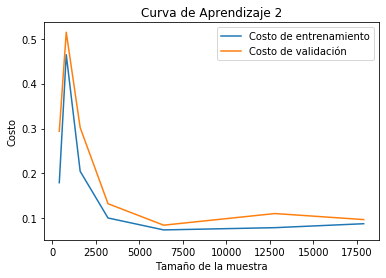

In [33]:
plt.plot(lista_m,lista_Jtrain, label = "Costo de entrenamiento")
plt.plot(lista_m,lista_Jcv,label = "Costo de validación")
plt.legend()
plt.title("Curva de Aprendizaje 2")
plt.xlabel("Tamaño de la muestra")
plt.ylabel("Costo")